<b> Title: </b> Group 11 Final Project Report - DSCI 100 002 

<b> Group members: </b> Katie Archer, Noor Naila Imtinan Himam, Matthew Yeung, Wenwen Zhao

<b>1. Introduction</b>
<br>
According to scientific research, pulsars are an uncommon form of neutron stars that emit regular pulses of radiation, varying from several seconds to milliseconds in frequency. The potent magnetic fields of these stars generate intense beams of light at both poles. These beams are periodically observed as the pulsar rotates quickly, and they can only be observed with large telescopes when they cross our line of sight from Earth (National Aeronautics and Space Administration, n.d.)

Although pulsars emit a pattern of radio emission that can be detected as they rotate, it can be challenging to distinguish between genuine signals and background noise. Pulsar candidates are being classified as binary classification issues using machine learning tools. The HTRU 2 dataset, which is used to train classification models, includes examples of both real and fake pulsar signals. The class labels used are 0 (negative) and 1 (positive), with the legitimate pulsar examples being the minority positive class. The eight continuous variables are obtained from the integrated pulse profile and the DM-SNR (Disperion Measure-Signal-to-Noise Ratio) curve, which describes the longitude-resolved version of the signal averaged in both time and frequency (Keith et al., 2010). Each candidate in the dataset is described by eight continuous variables, one class variable, and no astronomical information. The integrated pulse profile and the DM-SNR curve are used to determine the eight variables.

In this project, we aim to produce a KNN classification model from the integrated pulse profile and DM-SNR curve of pulsar candidates to classify whether signals are legitimate or spurious (real or fake pulsar). The data will be used to explore the correlation between two variables, the class imbalance and the combination of predictors that would create a model with the greatest accuracy.

<b>2. Preliminary exploratory data analysis:</b>


First, we load all of the libraries that we will need for the remainder of this project. This includes installing a package that will allow us to upsample our dataset later on.

In [1]:
#CAUTION: Takes a long time to load.
#install.packages(c("DiceDesign", "modeldata", "dials", "tune", "workflowsets"), dependencies = TRUE)
install.packages("tidymodels") #, dependencies = TRUE)
install.packages("themis")
remove.packages("rlang")
install.packages("corrplot")
#install.packages("tidyverse")
#install.packages("kknn")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Removing package from ‘/opt/conda/lib/R/library’
(as ‘lib’ is unspecified)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [1]:
install.packages("rlang")
library(rlang)
library(tidyverse)
library(repr)
library(tidymodels)
library(dplyr)
library(ggplot2)
library(GGally)
library(corrplot)
library(RColorBrewer)   
library(class)          
library(e1071)          
library(stringr)
library(themis)
devtools::install_github("tidymodels/tune")
set.seed(1)
options(repr.matrix.max.rows = 10)

Installing package into ‘/home/jupyter/R/x86_64-pc-linux-gnu-library/4.2’
(as ‘lib’ is unspecified)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.1     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ purrr::%@%()         masks rlang::%@%()
✖ dplyr::filter()      masks stats::filter()
✖ purrr::flatten()     masks rlang::flatten()
✖ purrr::flatten_chr() masks rlang::flatten_chr()
✖ purrr::flatten_dbl() masks rlang::flatten_dbl()
✖ purrr::flatten_int() masks rlang::flatten_int()
✖ purrr::flatten_lgl() masks rlang::flatten_lgl()
✖ purrr::flatten_raw() masks rlang::flatten_raw()
✖ purrr::invoke()      masks rlang::invoke()
✖ dplyr::lag()         m

<b>Summarize the data in at least one table </b>

We begin by reading in our dataset and tidying it by adding column names and removing any rows with missing values.

In [2]:
pulsar_data <- read_csv("pulsar_data.csv", col_names = c("mean_integrated_profile", "stand_dev_integrated_profile", "exc_kurtosis_integrated_profile", 
                                                         "skew_integrated_profile", "mean_dmsnr", "stand_dev_dmsnr", "exc_kurtosis_dmsnr", 
                                                         "skew_dmsnr", "class")) |>
               drop_na()
print("Table 1: Pulsar Dataset")
head(pulsar_data)

Rows: 17898 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): mean_integrated_profile, stand_dev_integrated_profile, exc_kurtosis...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "Table 1: Pulsar Dataset"


mean_integrated_profile,stand_dev_integrated_profile,exc_kurtosis_integrated_profile,skew_integrated_profile,mean_dmsnr,stand_dev_dmsnr,exc_kurtosis_dmsnr,skew_dmsnr,class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
140.56250,55.68378,-0.23457141,-0.6996484,3.199833,19.11043,7.975532,74.24222,0
102.50781,58.88243,0.46531815,-0.5150879,1.677258,14.86015,10.576487,127.39358,0
103.01562,39.34165,0.32332837,1.0511644,3.121237,21.74467,7.735822,63.17191,0
136.75000,57.17845,-0.06841464,-0.6362384,3.642977,20.95928,6.896499,53.59366,0
88.72656,40.67223,0.60086608,1.1234917,1.178930,11.46872,14.269573,252.56731,0
93.57031,46.69811,0.53190485,0.4167211,1.636288,14.54507,10.621748,131.39400,0


<b> Dataset Exploration Graph 1 (correlation): </b>

In [ ]:
options(repr.plot.width = 12, repr.plot.height = 12)
cor_pulse <- cor(pulsar_data)
corrplot(cor_pulse, type="upper", order="hclust",col=brewer.pal(n=8, name="RdYlBu")) 
print("Figure 1: Correlation plot #1")

In [ ]:
options(repr.plot.width = 17, repr.plot.height = 17)
correlation_pairs <- select(pulsar_data, "mean_integrated_profile":"skew_dmsnr")%>%
ggpairs() +
ggtitle("Figure 2: Correlation plot #2")

correlation_pairs

We can see that various pairs of variables have a different correlation value, where some have higher correlation values than others. 

<b> Dataset Exploration Graph 2 (variable distribution): </b>

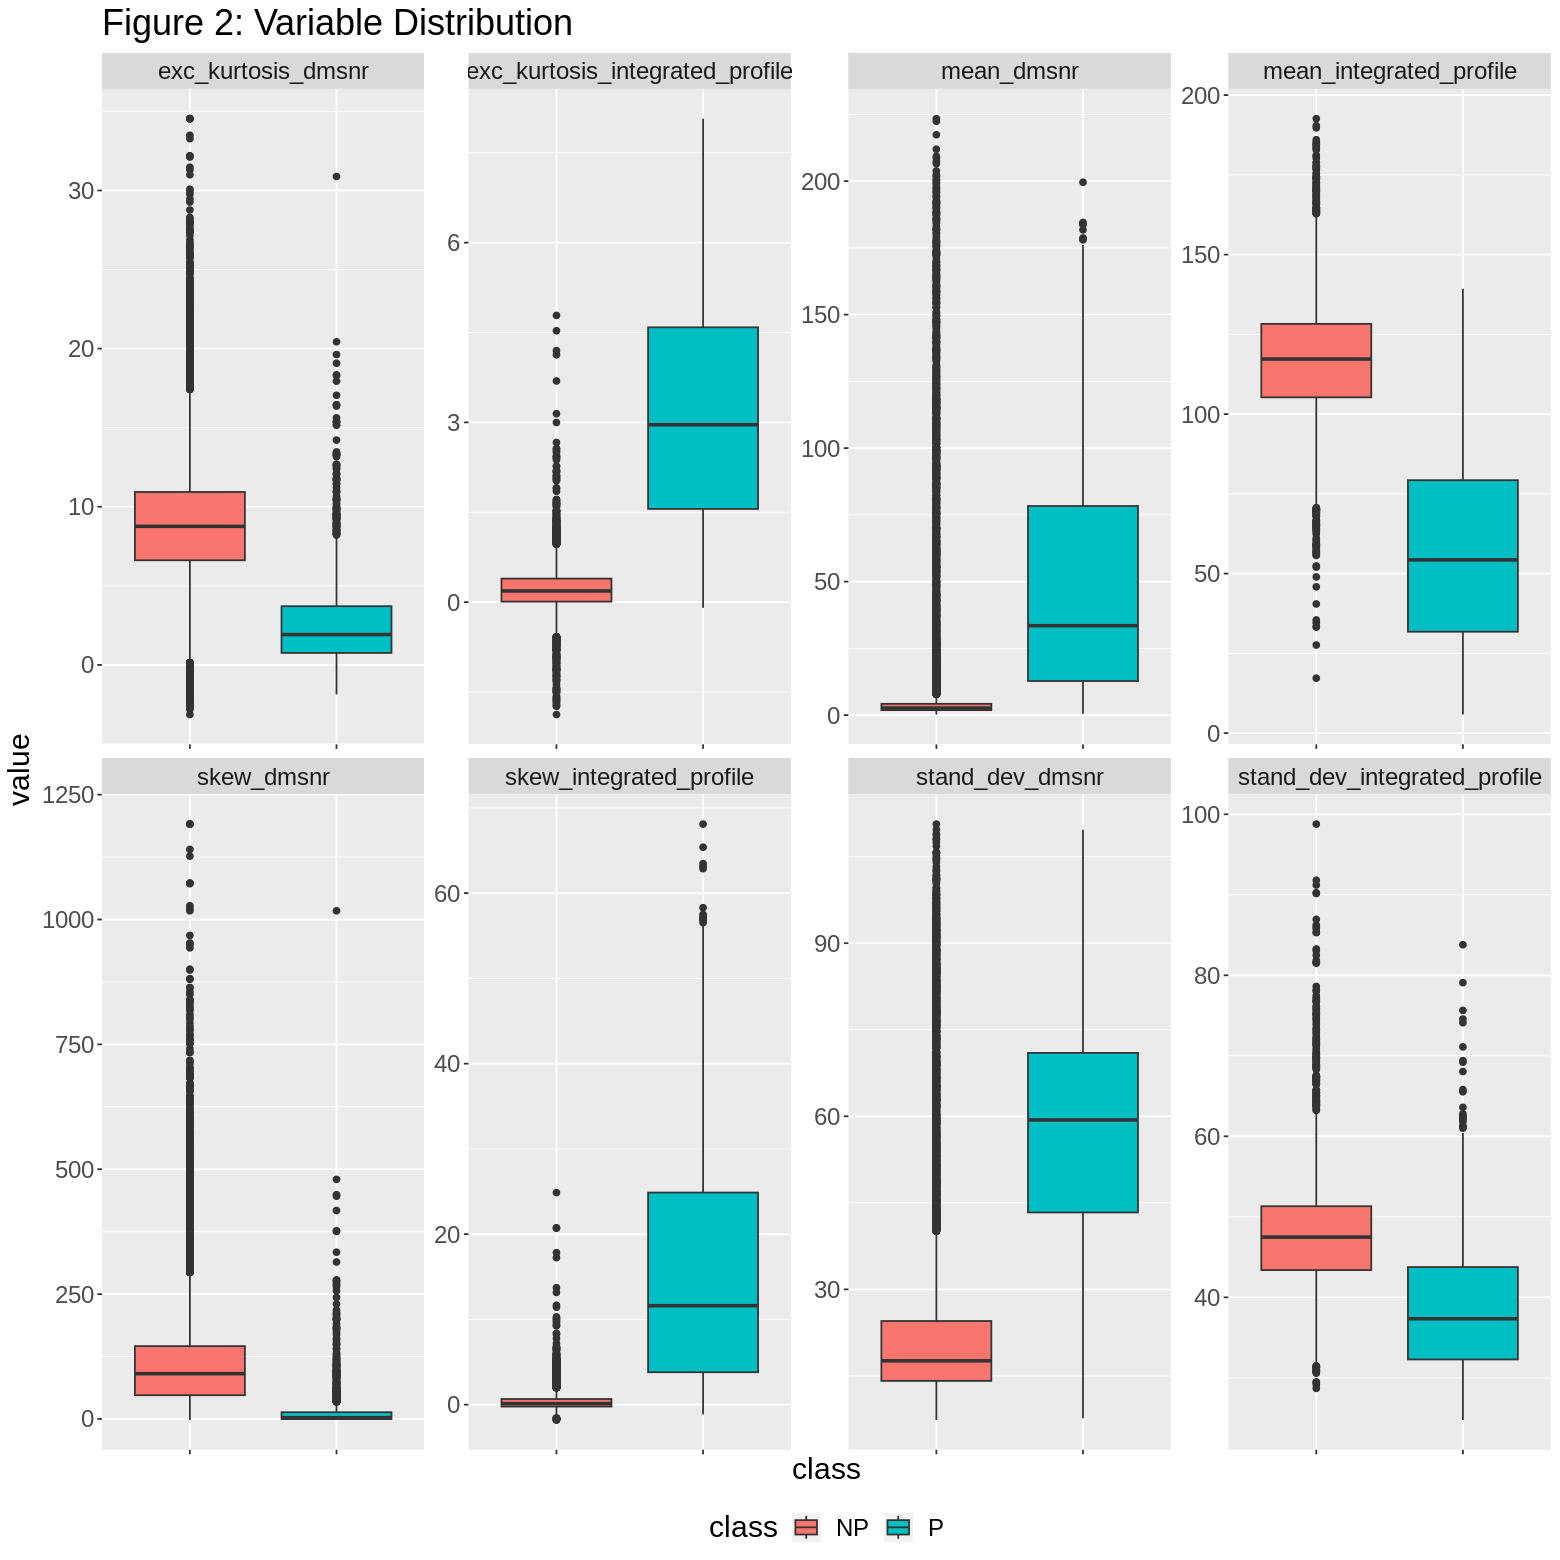

In [6]:
pulsar_data$class <- ifelse(pulsar_data$class == 1, "P", "NP")

options(repr.plot.height = 13, repr.plot.width = 13)

pulsar_data |> gather(predictors, value, -class) %>%
  ggplot(aes(class, value, fill = class)) +
  geom_boxplot() +
  facet_wrap(~predictors, scales = "free", ncol = 4) +
  theme(axis.text.x = element_blank(), legend.position="bottom") +
  theme(text = element_text(size = 18)) +
  ggtitle("Figure 3: Variable Distribution")

As shown above, the distribution graph above shows that some of the variables' values show a distinct difference between real and false pulsars.

Now, we look at the proportion of pulsars and non pulsars in the dataset to determine a data balancing method:

In [7]:
prop.table(table(pulsar_data$class))


        NP          P 
0.90842552 0.09157448 

In [8]:
table(pulsar_data$class)


   NP     P 
16259  1639 

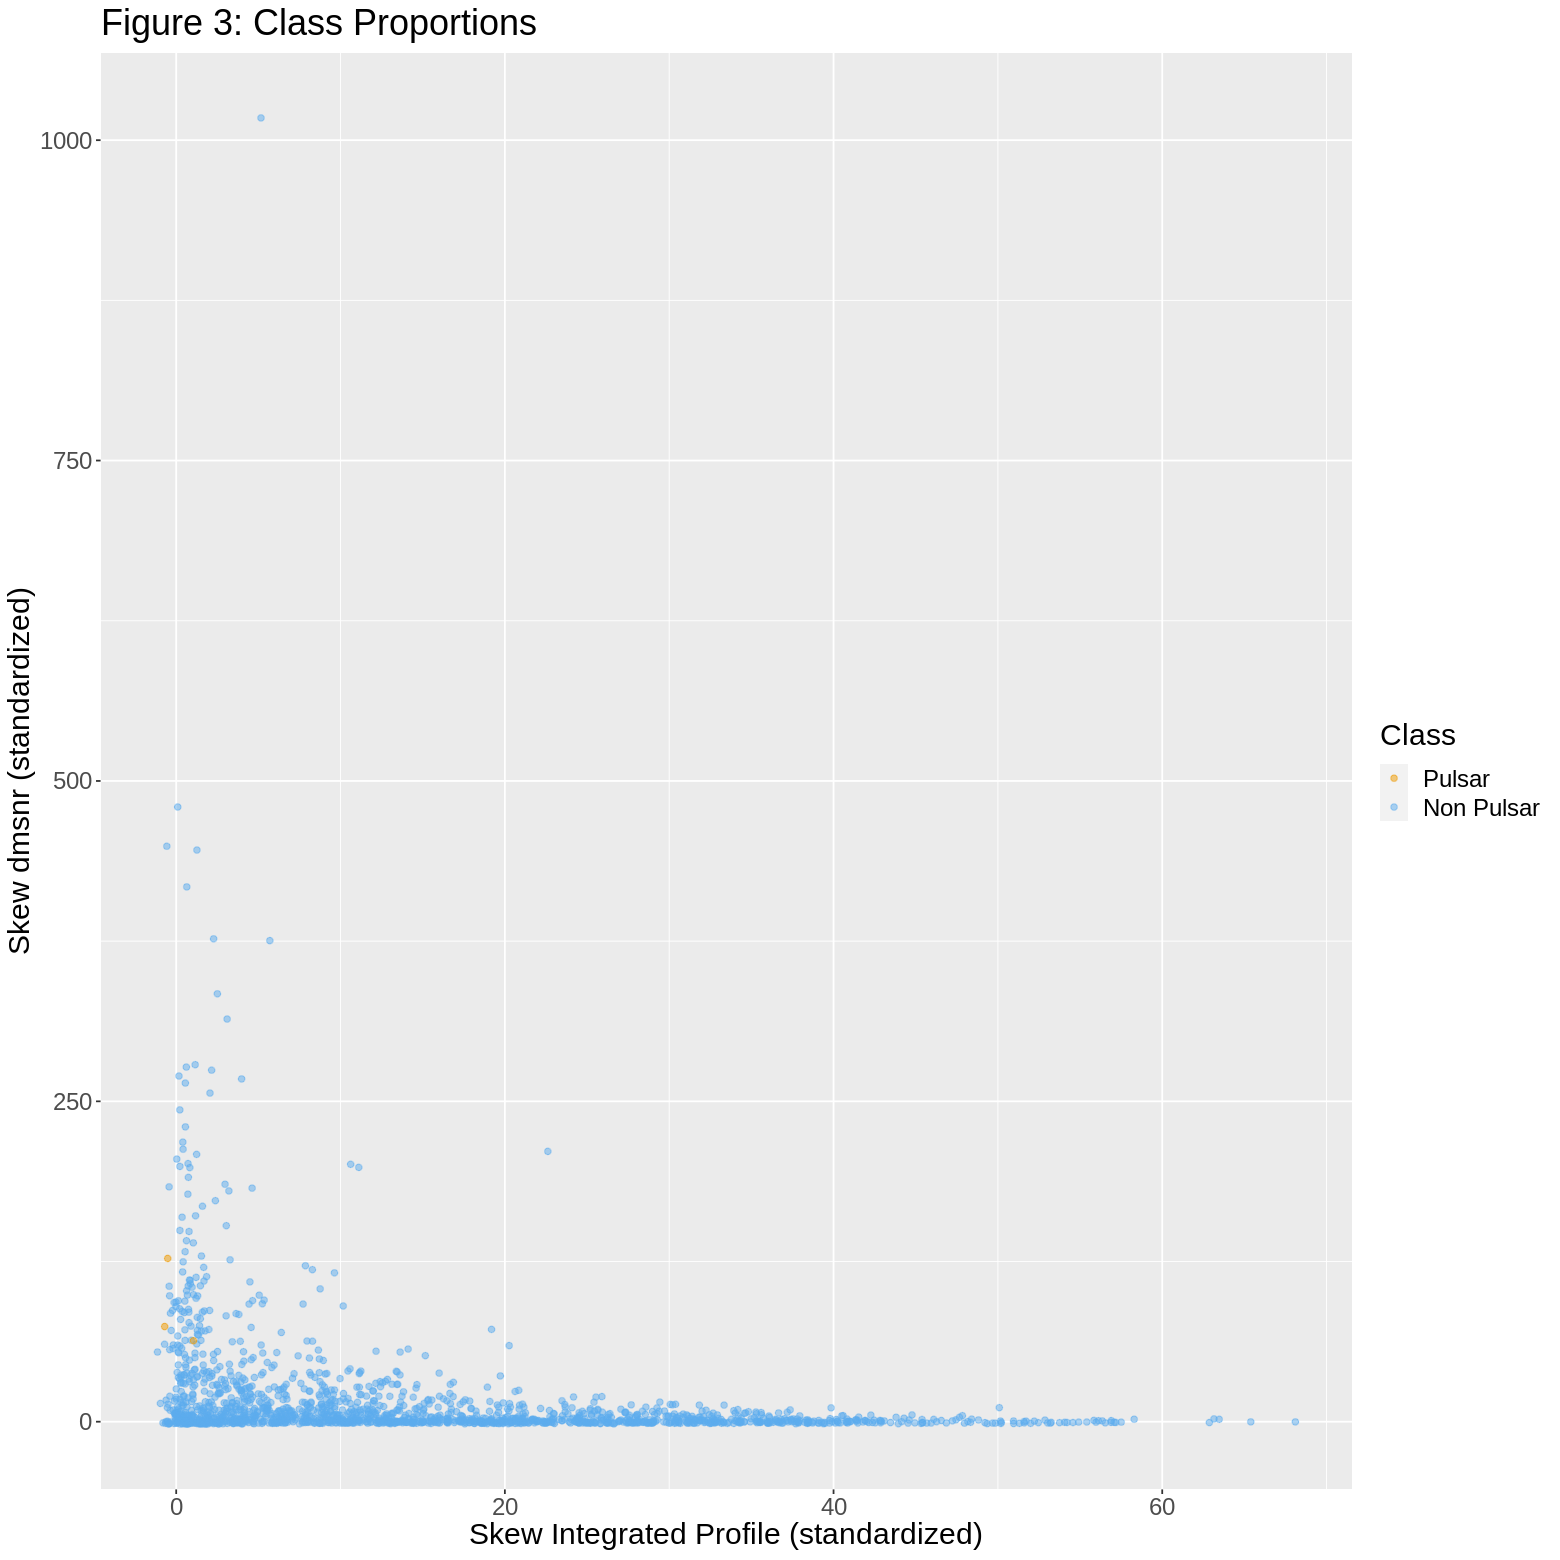

In [9]:
rare_pulsar <- bind_rows(
      filter(pulsar_data, class == "P"),
      pulsar_data |> filter(class == "NP") |> slice_head(n = 3)
    ) |>
    select(class, skew_integrated_profile, skew_dmsnr)

rare_plot <- rare_pulsar |>
  ggplot(aes(x = skew_integrated_profile, y = skew_dmsnr, color = class)) +
  geom_point(alpha = 0.5) +
  labs(x = "Skew Integrated Profile (standardized)", 
       y = "Skew dmsnr (standardized)",
       color = "Class") +
  scale_color_manual(labels = c("Pulsar", "Non Pulsar"), 
                     values = c("orange2", "steelblue2")) +
  theme(text = element_text(size = 18)) +
  ggtitle("Figure 4: Class Proportions")

rare_plot

As we can see from the proportions and the plot shown above in Figure 3, which uses two variables from the dataset, there are more non pulsars than pulsars. We must balance the number of pulsar points in the training set, otherwise our KNN classification model will be more likely to pick non pulsar as the majority class. Thus, the algorithm model will not learn correctly. 

For our purposes in this project, it will suffice to rebalance the data by oversampling the rare class. We will randomly duplicate observations of class 1 (real pulsars) until we have the same number of class 0 and class 1 in our training set.

**Data Analysis**

To begin our data analysis, we must randomly split the dataset into a training and testing set and specify that 75% of the data to be used to train our classification model. The training set will be used to train and tune our model while the testing set will be used to test the accuracy of our classification model. We also set the seed so the random splitting of our dataset can be reproduced later.

In [10]:
set.seed(1)
#change the class variable to be a factor type
pulsar_data <- pulsar_data |>
    mutate(class = as_factor(class))

#split the data
pulsar_split <- initial_split(pulsar_data, prop = 0.75, strata = class)
pulsar_train <- training(pulsar_split)
pulsar_test <- testing(pulsar_split) 

**Selecting Predictors**

To address our project question, we perform forward selection on the training set to determine how accurate our classification model would be, given various predictor combinations. For our purposes, it will be sufficient to use the training set to select our predictors as the training dataset is large enough. We will then select the set of predictors that is expected to yield the most accurate classifier in our data analysis.

In [11]:
names <- colnames(pulsar_train |> select(-class))
names

[1] "mean_integrated_profile"         "stand_dev_integrated_profile"   
[3] "exc_kurtosis_integrated_profile" "skew_integrated_profile"        
[5] "mean_dmsnr"                      "stand_dev_dmsnr"                
[7] "exc_kurtosis_dmsnr"              "skew_dmsnr"

In [12]:
example_formula <- paste("class", "~", paste(names, collapse="+"))
example_formula

[1] "class ~ mean_integrated_profile+stand_dev_integrated_profile+exc_kurtosis_integrated_profile+skew_integrated_profile+mean_dmsnr+stand_dev_dmsnr+exc_kurtosis_dmsnr+skew_dmsnr"

In [13]:
# create an empty tibble to store the results
predictor_accuracies <- tibble(size = integer(), 
                     model_string = character(), 
                     accuracy = numeric())

In [14]:
# store the total number of predictors
n_total <- length(names)

# stores selected predictors
selected <- c()

# for every size from 1 to the total number of predictors
for (i in 1:n_total) {
    # for every predictor still not added yet
    accs <- list()
    models <- list()
    for (j in 1:length(names)) {
        # create a model string for this combination of predictors
        preds_new <- c(selected, names[[j]])
        model_string <- paste("class", "~", paste(preds_new, collapse="+"))

        # create a recipe from the model string
        puls_recipe <- recipe(as.formula(model_string), 
                                data = pulsar_train) |>
                          step_scale(all_predictors()) |>
                          step_center(all_predictors())                        
        
        #set up a model
        knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
            set_engine("kknn") |>
            set_mode("classification")                                        

        puls_vfold <- vfold_cv(pulsar_train, v = 10, strata = class)
        
        # tune the KNN classifier with these predictors
        acc <- workflow() |>
          add_recipe(puls_recipe) |>
          add_model(knn_spec) |>
          tune_grid(resamples = puls_vfold, grid = 10) |>
          collect_metrics() |>
          filter(.metric == "accuracy") |>
          summarize(mx = max(mean))
        acc <- acc$mx |> unlist()

        # add this result to the dataframe
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    jstar <- which.max(unlist(accs))
predictor_accuracies <- predictor_accuracies |> 
      add_row(size = i, 
              model_string = models[[jstar]], 
              accuracy = accs[[jstar]])
    selected <- c(selected, names[[jstar]])
    names <- names[-jstar]
}
predictor_accuracies
print("Table 2: Predictor combination accuracies")

size,model_string,accuracy
<int>,<chr>,<dbl>
1,class ~ exc_kurtosis_integrated_profile,0.9768311
2,class ~ exc_kurtosis_integrated_profile+mean_dmsnr,0.9790660
3,class ~ exc_kurtosis_integrated_profile+mean_dmsnr+stand_dev_integrated_profile,0.9795871
4,class ~ exc_kurtosis_integrated_profile+mean_dmsnr+stand_dev_integrated_profile+stand_dev_dmsnr,0.9797366
5,class ~ exc_kurtosis_integrated_profile+mean_dmsnr+stand_dev_integrated_profile+stand_dev_dmsnr+skew_integrated_profile,0.9802573
6,class ~ exc_kurtosis_integrated_profile+mean_dmsnr+stand_dev_integrated_profile+stand_dev_dmsnr+skew_integrated_profile+skew_dmsnr,0.9797368
7,class ~ exc_kurtosis_integrated_profile+mean_dmsnr+stand_dev_integrated_profile+stand_dev_dmsnr+skew_integrated_profile+skew_dmsnr+exc_kurtosis_dmsnr,0.9794382
8,class ~ exc_kurtosis_integrated_profile+mean_dmsnr+stand_dev_integrated_profile+stand_dev_dmsnr+skew_integrated_profile+skew_dmsnr+exc_kurtosis_dmsnr+mean_integrated_profile,0.9785442


Based on the data above, the highest accuracy is obtained by using the 5 following predictors: exc_kurtosis_integrated_profile, stand_dev_dmsnr, stand_dev_integrated_profile, mean_dmsnr, and skew_integrated_profile.

Earlier, we saw that the percentage of observations corresponding to real pulsars is roughly 9%. A class imbalance is evident as there are more false pulsars than real pulsar observations.

In [15]:
#Class proportions in pulsar data set (Imbalanced)
num_obs <- nrow(pulsar_data)
pulsar_proportions <- pulsar_data |>
    group_by(class) |>
    summarize(n = n()) |>
    mutate(percent = 100*n/nrow(pulsar_data))
pulsar_proportions

print("Table 3: Class percentages")

class,n,percent
<fct>,<int>,<dbl>
NP,16259,90.842552
P,1639,9.157448


Here, we reproduce the random split of our data into a training and testing set with the "set.seed" function. We balance the proportions of real pulsars to false pulsar observations by upsampling the training set only, such that there is a ratio of 1:1 of real pulsars and false pulsars. The testing set will not be upsampled as this will be used to test our accuracy. To preprocess the data, we scale and center our predictors such that the variables have a mean of 0 and standard deviation of 1. We also build our recipe with the 5 predictors that yields the highest performance, obtained from forward selection. 

In [16]:
set.seed(1)
pulsar_split <- initial_split(pulsar_data, prop = 0.75, strata = class)
pulsar_train <- training(pulsar_split)
pulsar_test <- testing(pulsar_split) 


#Standardize and Upsample data to balance the training set
pulsar_recipe <- recipe(class ~ exc_kurtosis_integrated_profile, 
                        stand_dev_dmsnr, 
                        stand_dev_integrated_profile, 
                        mean_dmsnr, data = pulsar_train) |>               #input the 5 predictors we obtained from forward selection
    step_scale(all_predictors()) |>
    step_center(all_predictors()) |>
    themis::step_upsample(class, over_ratio = 1, skip = FALSE) |>
    prep()
pulsar_recipe

pulsar_train <- bake(pulsar_recipe, pulsar_train)
pulsar_train
print("Table 4: Training data")

pulsar_recipe <- recipe(class ~ ., data = pulsar_train)

#Check new proportions in training set
new_pulsar_proportions <- pulsar_train |>
    group_by(class) |>
    summarize(n = n()) |>
    mutate(percent = 100*n/nrow(pulsar_train))
new_pulsar_proportions
print("Table 5: Upsampled class percentages")



── Recipe ──────────────────────────────────────────────────────────────────────



── Inputs 

Number of variables by role

outcome:   1
predictor: 1



── Training information 

Training data contained 13423 data points and no incomplete rows.



── Operations 

• Scaling for: exc_kurtosis_integrated_profile | Trained

• Centering for: exc_kurtosis_integrated_profile | Trained

• Up-sampling based on: class | Trained



exc_kurtosis_integrated_profile,class
<dbl>,<fct>
-0.009077165,NP
-0.143049363,NP
-0.512672218,NP
0.053749649,NP
-0.418436890,NP
⋮,⋮
3.8811359,P
3.0779063,P
0.7525602,P


class,n,percent
<fct>,<int>,<dbl>
NP,12200,50
P,12200,50


Now we perform cross-validation on the training set in order to select the best K parameter value for our classifier (number of neighbors). To do this, we perform 10-fold cross-validation. But first, we build a classification model that specifies that the number of neighbors to tune. We also create a tibble that contains each K value that we want to test.

In [ ]:
#build the model
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
            set_engine("kknn") |>
            set_mode("classification")

#Create a tibble for the K values
k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 3))
#k_vals       
print("Table 6: Test K values")

#Set up and perform 10 fold cross validation
pulsar_vfold <- vfold_cv(pulsar_train, v = 10, strata = class)

knn_results <- workflow() |>
               add_recipe(pulsar_recipe) |>
               add_model(knn_spec) |>
               tune_grid(resamples = pulsar_vfold, grid = k_vals) |>
               collect_metrics() #assess the accuracy 
knn_results
("Table 7: Accuracy metrics")

To determine the best K to use, we filter the metrics collected from cross validation and plot the accuracy against the K values we tested.

In [ ]:
accuracies <- knn_results |> 
       filter(.metric == "accuracy")

accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       labs(x = "Neighbors", y = "Accuracy Estimate") +
       ggtitle("Figure 5: Accuracy vs. K") +
       theme(text = element_text(size = 20))
accuracy_versus_k

Based on the above plot, we see that the accuracy decreases quite steeply as the number of neighbors increases, before leveling off from around K = 16** onwards. We choose K = 17** for our classification model because the accuracy is high at this point, and the accuracy does not change drastically when looking at similar K values. Overall, we want to avoid overfitting the data by selecting too few neighbors, and 17** is an odd number (given that K-nearest neighbors classifies observations based on a majority rules system, using an even number of neighbors could be problematic in the event of a tie, since our class variable is binary). 

Upon determining the optimal K value for our classifier, we can finally predict on our testing set. As done below, we use the same recipe as before, but a new model that specifies the number of neighbors, K = 17** is built. Once we have used the model to predict the classes of the observations in the test set, we take a confusion matrix to view the accuracy.

In [ ]:
knn_spec_final <- nearest_neighbor(weight_func = "rectangular", neighbors = 17) |>
                    set_engine("kknn") |>
                    set_mode("classification")

pulsar_fit_final <- workflow() |>
        add_recipe(pulsar_recipe) |>
        add_model(knn_spec_final) |>
        fit(data = pulsar_train)

pulsar_test_predictions_final <-  predict(pulsar_fit_final, pulsar_test) |>
        bind_cols(pulsar_test)

pulsar_test_predictions_final           
print("Table 8: Test data with the classifier's predictions")

confusion_final <- pulsar_test_predictions_final |>
    conf_mat(truth = class, estimate = .pred_class)
confusion_final
print("Table 9: Confusion matrix")

To visualize the accuracy of our classification model, we create a new column in the predictions table that will allow us to produce a visualization of the test data in such a way that colour-coding the observations will provide further insight on information stored in the confusion matrix. (***not worded very well)

In [ ]:
mutated_predictions <- pulsar_test_predictions_final |>
    mutate(new_cat = case_when(.pred_class == NP & class == NP ~ "False pulsar, correctly classified",
                               .pred_class == P & class == P ~ "Real pulsar, correctly classified",
                               .pred_class == P & class == NP ~ "False pulsar, incorrectly classified",
                               .pred_class == NP & class == P ~ "Real pulsar, incorrectly classified"))
mutated_predictions
print("Table 10: Predicted test set with clear accuracy labels")

<b> Visualization: Classifier accuracy </b>

In [ ]:
options(repr.plot.height = 10, repr.plot.width = 14)

#First 2 predictors
plot_1 <- ggplot() +
    geom_point(data = mutated_predictions, mapping = aes(x = exc_kurtosis_integrated_profile, 
                                                              y = mean_dmsnr, colour = new_cat), alpha = 0.5) +
    labs(x = "Scaled Excess Kurtosis - Integrated Profile", y = "Scaled Mean - DMSNR curve", colour = "Prediction") +
    ggtitle("Figure 6: Classifier accuracy with regards to mean of DMSNR
                \ncurve and excess kurtosis of integrated profile") +
    scale_color_brewer(palette = "Dark2") +
    theme(text = element_text(size = 20))
plot_1



#Next 2 predictors
plot_2 <- ggplot() +
    geom_point(data = mutated_predictions, mapping = aes(x = skew_dmsnr,
                                                              y = skew_integrated_profile, colour = new_cat), alpha = 0.5) +
    labs(x = "Scaled Skewness - DMSNR curve", y = "Scaled Skewness - Integrated Profile", colour = "Prediction") +
    ggtitle("Figure 7: Classifier accuracy with regards to skewkness
                \nof both DMSNR curve and integrated profile") +
    scale_color_brewer(palette = "Dark2") +
    theme(text = element_text(size = 20))
plot_2



#Last 2 predictors
plot_3 <- ggplot() +
    geom_point(data = mutated_predictions, mapping = aes(x = stand_dev_integrated_profile, 
                                                             y = exc_kurtosis_dmsnr, colour = new_cat), alpha = 0.5) +
    labs(x = "Scaled Standard Deviation - Integrated Profile", y = "Scaled Excess Kurtosis - DMSNR curve", colour = "Prediction") +
    ggtitle("Figure 8: Classifier accuracy with regards to excess kurtosis of
                \nDMSNR curve and standard deviation of integrated profile") +
    scale_color_brewer(palette = "Dark2") +
    theme(text = element_text(size = 20))
plot_3

As seen in the plots above, there are very few observations in the testing set that were incorrectly classified. This indicates that our model is quite accurate. We can represent the accuracy of our model as a percentage, as well:

In [ ]:
#From the confusion matrix:

accuracy_perc <- ((3838 + 3853)/8130)*100
accuracy_perc

Therefore, <b> ~__% </b> is a good estimate of how accuracte our classification model is.

<b>Discussion </b>

summarize what you found: 

We found that training a classifier with our predictors (name them*) yields the most accurate predictions on new observations (i.e. the testing set). The accuracy of our model is __.

The high accuracy of the model trained with the predictors from the HTRU2 data set on new observations, as reflected in the testing set, is an interesting and promising finding. It suggests that the predictors used in the model are indeed effective in identifying pulsar candidates, which aligns with the initial hypothesis of the study. 

(Before upsampling I wasn’t expecting a really high prediction accuracy with any combination of predictors, due to how rare the real pulsars were in the original dataset
-Also, I don’t think I was expecting that the most accurate classifier would come from using 6 of the 8 variables available to us in the dataset → in our class readings it was mentioned that using very few or many predictors often harms how good the classifier is at making predictions (would have expected between 2-4 predictors to give the highest accuracy)→ **Due to the rarity of real pulsars in the original dataset, we did not expect to achieve a high prediction accuracy with any combination of predictors prior to upsampling. In addition, in contrast to what we had anticipated, we discovered that using 6 of the dataset's 8 available variables allowed us to create the most accurate classifier. This was unexpected because we had read in class that using either too few or too many predictors could reduce the classifier's accuracy, and we had anticipated that using 2-4 predictors would produce the highest accuracy. This unexpected result casts doubt on accepted wisdom and emphasises the nuanced interplay between predictor choice and pulsar classification prediction accuracy. It is necessary to conduct additional research and analysis to comprehend the underlying**


The accurate prediction of new observations can help validate the existence of pulsars and provide insights into their properties, which could improve our understanding of pulsar candidates and their characteristics. This may increase our understanding of astrophysical processes and enhance our capacity to find and investigate pulsars in the future. Furthermore, the model's accuracy may have useful implications for pulsar research. It might be used, for instance, to streamline the procedure for picking pulsar candidates in extensive surveys like the High Time Resolution Universe Survey.

The accuracy of the model might be improved through further research and comparisons with current approaches, which would also advance pulsar classification techniques.Additionally, the model's accuracy could be compared to other existing methods or models to assess its superiority and potential for further improvement.



After performing predictor selection, we found that using four predictors - mean of the integrated profile, standard deviation of the integrated profile, mean of the DM-SNR curve, and standard deviation of the DM-SNR curve - led to the highest accuracy.

Our findings suggest that these four predictors provide useful information for accurately classifying pulsar candidates as legitimate or spurious. Future research could explore whether additional predictors could further improve classification accuracy or if these four predictors are sufficient for classification purposes. Additionally, our results demonstrate the potential for using machine learning techniques to classify pulsar candidates with high accuracy and have implications for the field of astronomy more broadly.
This project could lead to future questions such as: How well does the developed model perform on different datasets of pulsar candidates collected from other surveys? Can the identified pulsars be used for practical applications such as navigation or communication systems?

In conclusion, our project demonstrates the potential for machine learning techniques to accurately classify pulsar candidates as legitimate or spurious based on information from their integrated pulse profile and DM-SNR curve. We found that the combination of excess kurtosis of the integrated profile, skewness of the DM-SNR curve, standard deviation of the integrated profile, and mean of the DM-SNR curve provided the highest accuracy in distinguishing between real and fake pulsar signals, with an accuracy of approximately 95%.

These findings have important implications for the field of astronomy and astrophysics, as they demonstrate the potential for machine learning to improve our ability to identify and classify celestial objects in large datasets. Future studies could build on this work by exploring additional predictors and refining the classification models to further increase accuracy and efficiency.

Overall, our project provides valuable insights into the use of machine learning for astronomical data analysis, and highlights the potential for this approach to enhance our understanding of the universe.

**References**

Dr Robert Lyon, University of Manchester, School of Physics and Astronomy, Alan Turing Building, Manchester M13 9PL, United Kingdom, robert.lyon '@' manchester.ac.uk

Keith, M. J., et al. (2010). The HTRU survey. Handbook of pulsar astronomy, 379-422.

United States. National Aeronautics and Space Administration. NASA technical note. Washington :National Aeronautics and Space Administration.

Paula, G. (2020, February 5). Creating a new variable under conditions of other two variables. Posit Community. Retrieved April 13, 2023, from https://community.rstudio.com/t/creating-a-new-variable-under-conditions-of-other-two-variables/51825  

do we need to cite the textbook?
do we need embedded citations?